In [67]:
from foronoi import Voronoi, Polygon, Visualizer, VoronoiObserver
from foronoi.graph import HalfEdge, Vertex
from typing import List, Dict
import numpy as np
import sys
import json

num_points = 10
num_points_boundary = 10

np.random.seed(0)

# 生成随机角度
angles = 2 * np.pi * np.random.rand(num_points)

# 生成均匀分布的半径，使用平方根方法以确保均匀分布在圆内
radii = np.sqrt(np.random.rand(num_points))

# 计算点的坐标
x = radii * np.cos(angles)
y = radii * np.sin(angles)

# Define some points (a.k.a sites or cell points)
points = list(zip(x, y))



# 生成均匀分布的角度
angles_boundary = np.linspace(0, 2 * np.pi, num_points_boundary, endpoint=False)

# 计算单位圆上点的坐标
x = np.cos(angles_boundary)
y = np.sin(angles_boundary)

points_boundary = list(zip(x, y))
# Define a bounding box / polygon
polygon = Polygon(points_boundary)

# Initialize the algorithm
v = Voronoi(polygon)

# Attach a Voronoi Observer that monitors and visualizes the construction of 
# the Voronoi Diagram step-by-step. See for more information 
# examples/quickstart.py or examples/observers.py.
#v.attach_observer(VoronoiObserver())

# Create the diagram
v.create_diagram(points=points)

# Get properties. See more examples in examples/quickstart.py
edges = v.edges
vertices = v.vertices
arcs = v.arcs
# Plotting
# Note: plot_border_to_site() indicates with dashed line to which site a border 
# belongs. The site's first edge is colored green.


In [68]:
Visualizer(v, canvas_offset=1).plot_edges(show_labels=False)

# print(len(edges))

In [69]:
sites=v.sites

with open('..//datasets//voronoi//voronoi_data_for_training.txt', 'w') as file:
    for i in range(len(sites)):
        file.write(f"f{i} ")
        file.write(f"{sites[i].xy}\n")
        adj_edges=sites[i].borders()
        for j in range(len(adj_edges)):
            file.write(f"e{adj_edges[j].origin.xy}")
            file.write(f"{adj_edges[j].target.xy}\n")


In [70]:
def extract_edges_data(sites, edge_indices: Dict,site_indices: Dict) -> List[Dict]:
    edges_data = []
    for site in sites:
        for edge in site.borders():
            edge_info = {
                'index': edge_indices[edge],  # 从外部字典获取索引
                'origin': edge.origin.xy,
                'target': edge.target.xy,
                'twin': edge_indices.get(edge.twin,-1),
                'next': edge_indices[edge.next],
                'prev': edge_indices[edge.prev],
                'site': site_indices[site]
            }
            edges_data.append(edge_info)
    return edges_data

def extract_sites_data(sites, site_indices: Dict, edge_indices: Dict,vertex_indices: Dict) -> List[Dict]:
    sites_data = []
    for site in sites:
        site_info = {
            'index': site_indices[site],  # 从外部字典获取索引
            'xy': [site.x,site.y],
            'borders': [edge_indices[border] for border in site.borders()],  # 使用边的index
            'vertices': [vertex_indices[vertex] for vertex in site.vertices()],
            'first_edge': edge_indices[site.first_edge]
        }
        sites_data.append(site_info)
    return sites_data

def extract_vertices_data(vertex_indices: Dict, edge_indices: Dict) -> List[Dict]:
    vertices_data = []
    for vertex,vertex_idx in vertex_indices.items():
        vertex_info = {
            'index': vertex_idx,  # 从外部字典获取索引
            'xy': [vertex.x,vertex.y],
            # 'edges':[edge_indices[edge] if edge in edge_indices else edge_indices[edge.twin] for edge in vertex.connected_edges]
            'edges':[edge_indices[edge] for edge in vertex.connected_edges]

        }
        vertices_data.append(vertex_info)
    return vertices_data

# 生成Voronoi结构数据集
def generate_voronoi_dataset(v):
    # 为 edges, vertices 和 sites 创建索引映射
    edge_indices = {}
    site_indices = {}
    edge_idx = 0
    vertex_idx = 0
    vertex_indices={}
    for idx,site in enumerate(v.sites):
        site_indices[site] = idx
        for j,edge in enumerate(site.borders()):
            edge_indices[edge] =  edge_idx+j

        for vertex in site.vertices():
            if vertex not in vertex_indices:
                vertex_indices[vertex]=vertex_idx
                vertex_idx=vertex_idx+1
        edge_idx = edge_idx + len(site.borders())

    edges_data = extract_edges_data(v.sites, edge_indices,site_indices)
    sites_data = extract_sites_data(v.sites, site_indices, edge_indices,vertex_indices)
    vertex_data=extract_vertices_data(vertex_indices,edge_indices)

    voronoi_dataset = {
        'edges': edges_data,
        'sites': sites_data,
        'vertices': vertex_data
    }

    return voronoi_dataset

# 将数据集保存为json文件
def save_voronoi_to_json(voronoi_data, filename="voronoi_data.json"):
    with open(filename, 'w') as f:
        json.dump(voronoi_data, f, indent=4)


In [71]:
edge_indices = {}
site_indices = {}
edge_idx = 0
vertex_idx = 0
vertex_indices={}
for idx,site in enumerate(v.sites):
    site_indices[site] = idx
    for j,edge in enumerate(site.borders()):
        edge_indices[edge] =  edge_idx+j
    for vertex in site.vertices():
        if vertex not in vertex_indices:
            vertex_indices[vertex]=vertex_idx
            vertex_idx=vertex_idx+1
    edge_idx = edge_idx + len(site.borders())


def extract_vertices_data_test(vertex_indices: Dict, edge_indices: Dict) -> List[Dict]:
    vertices_data = []
    error_vertex=[]
    for vertex,vertex_idx in vertex_indices.items():
        try:
            vertex_info = {
                'index': vertex_idx,  # 从外部字典获取索引
                'xy': [vertex.x,vertex.y],
                # 'edges':[edge_indices[edge] if edge in edge_indices else edge_indices[edge.twin] for edge in vertex.connected_edges]
                'edges':[edge_indices[edge] for edge in vertex.connected_edges]

            }
            vertices_data.append(vertex_info)
        except KeyError:
            error_vertex.append(vertex)
    return vertices_data, error_vertex

vertex_data,error_vertex=extract_vertices_data_test(vertex_indices,edge_indices)




In [72]:
error_edge = error_vertex[1].connected_edges
for edge in error_edge:
    print(edge.origin.xy,edge.target.xy)

(-0.8871220773075352, -0.34740252438113983) (-0.8805904719605225, 0.1965162225611616)
(-0.8871220773075352, -0.34740252438113983) (-0.8350773461503205, -0.5075797366604116)
(-0.8871220773075352, -0.34740252438113983) (-1.0, 1.2246467991473532e-16)


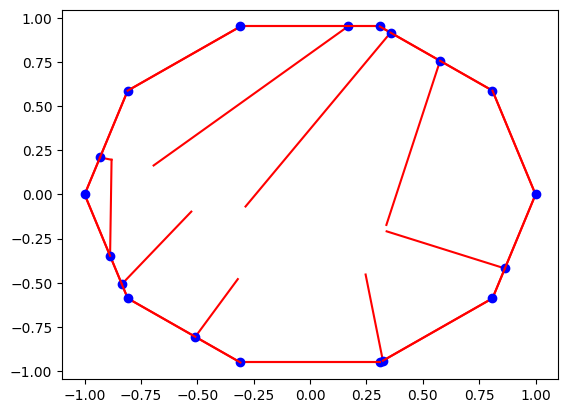

19


In [77]:
from matplotlib import pyplot as plt

plt.figure()
for vertex in error_vertex:
    for edge in vertex.connected_edges:
        plt.plot([edge.origin.x,edge.target.x],[edge.origin.y,edge.target.y],color='r')
    plt.plot(vertex.x,vertex.y,'bo')
plt.show()  
print(len(error_vertex))

In [74]:
# 生成并保存Voronoi数据集
voronoi_data = generate_voronoi_dataset(v)


KeyError: None/P7

In [22]:
save_voronoi_to_json(voronoi_data, "..//datasets//voronoi//voronoi_data.json")

print(f"Voronoi data has been saved to 'voronoi_data.json'")

Voronoi data has been saved to 'voronoi_data.json'
